# Introduction

This project focuses on object detection to differentiate between civilian and warship vessels, an application useful for surveillance and defense purposes. 

Accurate identification of ship types can assist in monitoring coastal areas, tracking potential threats, and informing defense decisions. 

This project aims to distinguish between these two categories using deep learning for high accuracy in real-world scenarios.

# Imports

In [1]:
import os
import random
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage import io
import matplotlib.pyplot as plt
from IPython.display import display, Image, HTML, Video
import cv2

from ultralytics import YOLO

# Dataset

The dataset used is from [Mcships](https://github.com/ZhengYitong2333/Mcships), which provides a diverse collection of labelled images of various types of ships. 

This dataset was formatted for YOLO with an accompanying script, allowing for direct use in training YOLO models. 

The dataset was split into training, validation, and test sets with a 50:20:30 ratio. Specifically, there are 4,048 images (\~50%) in the training set, 1,637 images (\~20%) in the validation set, and 2,311 images (\~30%) in the test set. This distribution ensures that the model is trained on a majority of the data, while still allowing for proper validation and testing.

In [2]:
def count_classes(dataset_path):
    class_count = {}
    
    for split in ['train', 'val', 'test']:
        split_path = os.path.join(dataset_path, 'labels', split)
        
        # Check if the directory exists
        if not os.path.exists(split_path):
            print(f"Warning: {split_path} not found!")
            continue
        
        # Iterate through all .txt files in the split directory
        for filename in os.listdir(split_path):
            if filename.endswith('.txt'):
                file_path = os.path.join(split_path, filename)

                with open(file_path, 'r') as f:
                    for line in f:
                        class_id = int(line.split()[0])

                        if class_id in class_count:
                            class_count[class_id] += 1
                        else:
                            class_count[class_id] = 1
    
    return class_count

In [3]:
dataset_path = ".\datasets"

In [4]:
class_count = count_classes(dataset_path)

print("Class occurrences in the dataset:")
for class_id, count in class_count.items():
    print(f"Class {class_id}: {count} occurrences")

Class occurrences in the dataset:
Class 0: 5945 occurrences
Class 1: 5382 occurrences


In [5]:
classes = ['civilianship', 'warship']

In [6]:
train_images_path = os.path.join(dataset_path, 'images', 'train')
train_images_path

'.\\datasets\\images\\train'

In [7]:
all_train_images_paths = glob(f'{train_images_path}/*.jpg')
all_train_images_paths[:5]

['.\\datasets\\images\\train\\000001.jpg',
 '.\\datasets\\images\\train\\000004.jpg',
 '.\\datasets\\images\\train\\000005.jpg',
 '.\\datasets\\images\\train\\000006.jpg',
 '.\\datasets\\images\\train\\000007.jpg']

In [8]:
train_labels_path = os.path.join(dataset_path, 'labels', 'train')
train_labels_path

'.\\datasets\\labels\\train'

In [9]:
all_train_labels_paths = glob(f'{train_labels_path}/*.txt')
all_train_labels_paths[:5]

['.\\datasets\\labels\\train\\000001.txt',
 '.\\datasets\\labels\\train\\000004.txt',
 '.\\datasets\\labels\\train\\000005.txt',
 '.\\datasets\\labels\\train\\000006.txt',
 '.\\datasets\\labels\\train\\000007.txt']

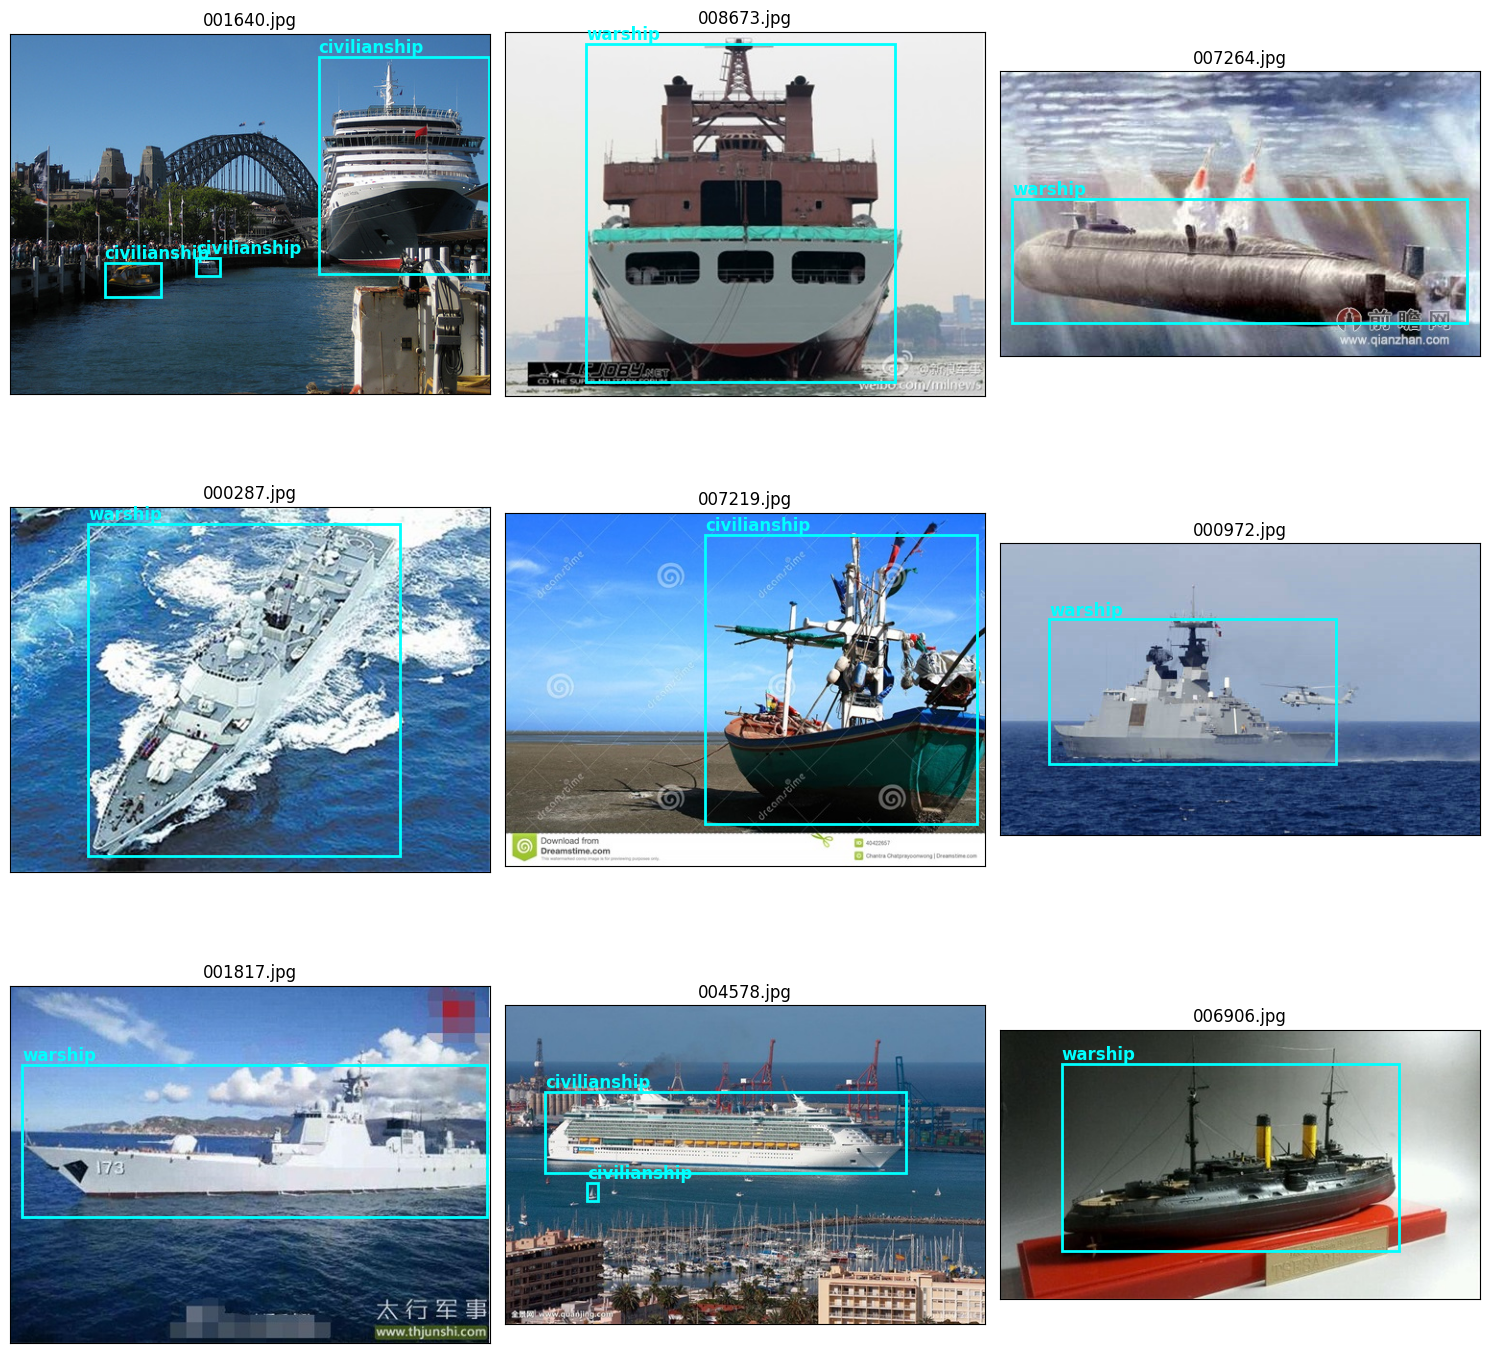

In [10]:
num_images = 9
random_indices = random.sample(range(len(all_train_images_paths)), num_images)

fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for idx, ax in zip(random_indices, axes.flatten()):
    image_path = all_train_images_paths[idx]
    label_path = all_train_labels_paths[idx]
    
    img = io.imread(image_path)
    height, width, _ = img.shape  # Get image dimensions for scaling
    
    # Read label file with YOLO format (class_id x_center y_center width height)
    with open(label_path, 'r') as label_file:
        lines = label_file.readlines()
    
    ax.imshow(img)
    
    # Process each object in the label file
    for line in lines:
        parts = line.strip().split()
        class_id = int(parts[0])  # Class ID (integer)
        
        x_center = float(parts[1]) * width  
        y_center = float(parts[2]) * height 
        box_width = float(parts[3]) * width  
        box_height = float(parts[4]) * height
        
        x_min = x_center - (box_width / 2)
        y_min = y_center - (box_height / 2)
        x_max = x_center + (box_width / 2)
        y_max = y_center + (box_height / 2)
        
        # Create bounding box
        rect = patches.Rectangle(
            (x_min, y_min), box_width, box_height,
            linewidth=2, edgecolor='cyan', facecolor='none'
        )
        ax.add_patch(rect)
        
        # Add class name near bounding box
        class_name = classes[class_id]  # Get the class name from the classes list
        ax.text(x_min, y_min - 5, class_name, color='cyan', fontsize=12, weight='bold')

    image_name = image_path.split('\\')[-1] 
    ax.set_title(image_name)

    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

# Model Training & Evaluation

The model chosen for finetuning is the pre-trained `yolo11n.pt` model, which was selected due to its balance of speed and accuracy. 

This model is lightweight yet powerful, making it suitable for rapid inferences on real-time surveillance systems. 

By finetuning it on the Mcships dataset, we adapt the model to focus specifically on civilian and warship categories, improving its detection accuracy for this task.

In [13]:
dataset_yaml_path = './dataset.yaml'
dataset_path
EPOCHS = 100

# Load the pre-trained YOLO model (e.g., yolo11n.pt is a COCO-pretrained model)
model = YOLO("yolo11n.pt")

# Train the model on your custom dataset for 100 epochs
results = model.train(data=dataset_yaml_path, epochs=EPOCHS, imgsz=640)

Ultralytics 8.3.28  Python-3.9.20 torch-2.4.1+cu124 CUDA:0 (NVIDIA GeForce RTX 2080 SUPER, 8192MiB)
engine\trainer: task=detect, mode=train, model=yolo11n.pt, data=./dataset.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train6, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, sh

train: Scanning C:\Users\yangy\Downloads\red-dragon-advanced-cv-course-project\datasets\labels\train... 4048 images, 0 


train: New cache created: C:\Users\yangy\Downloads\red-dragon-advanced-cv-course-project\datasets\labels\train.cache


val: Scanning C:\Users\yangy\Downloads\red-dragon-advanced-cv-course-project\datasets\labels\val... 1637 images, 1 back


val: New cache created: C:\Users\yangy\Downloads\red-dragon-advanced-cv-course-project\datasets\labels\val.cache
Plotting labels to runs\detect\train6\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train6
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.46G      1.187      2.041       1.39         72        640: 100%|██████████| 253/253 [02:48<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:28


                   all       1637       2301      0.393      0.323      0.286      0.147

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.39G      1.301      1.596      1.463         46        640: 100%|██████████| 253/253 [00:41<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11


                   all       1637       2301      0.682      0.591      0.661      0.376

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.41G       1.33       1.47      1.486         43        640: 100%|██████████| 253/253 [00:38<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11


                   all       1637       2301       0.51      0.498      0.468      0.247

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100       2.4G      1.305      1.397      1.462         58        640: 100%|██████████| 253/253 [00:37<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10

                   all       1637       2301      0.704      0.635      0.711      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.38G      1.267      1.321      1.437         47        640: 100%|██████████| 253/253 [00:38<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10

                   all       1637       2301      0.671      0.638      0.692       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.39G      1.231      1.254      1.417         50        640: 100%|██████████| 253/253 [00:38<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10

                   all       1637       2301      0.708      0.649      0.704      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.37G       1.21      1.206      1.399         50        640: 100%|██████████| 253/253 [00:37<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10

                   all       1637       2301      0.785      0.711      0.793      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.39G      1.186      1.162      1.381         48        640: 100%|██████████| 253/253 [00:36<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10

                   all       1637       2301      0.787      0.673      0.773      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100       2.4G      1.178      1.141      1.373         61        640: 100%|██████████| 253/253 [00:38<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11

                   all       1637       2301      0.778      0.705      0.784      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.37G      1.159      1.103      1.358         53        640: 100%|██████████| 253/253 [00:38<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10


                   all       1637       2301      0.774      0.723      0.791       0.51

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.39G      1.143      1.096      1.354         59        640: 100%|██████████| 253/253 [00:37<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:09

                   all       1637       2301      0.765      0.672      0.748      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.37G      1.139      1.062      1.341         38        640: 100%|██████████| 253/253 [00:37<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:09

                   all       1637       2301      0.798      0.718      0.804      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100       2.4G      1.116      1.042      1.332         63        640: 100%|██████████| 253/253 [00:38<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:09

                   all       1637       2301      0.838      0.751      0.843      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.39G      1.129       1.04      1.332         51        640: 100%|██████████| 253/253 [00:37<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10

                   all       1637       2301      0.813      0.755      0.831      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.39G      1.114      1.023      1.326         56        640: 100%|██████████| 253/253 [00:39<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10

                   all       1637       2301      0.808      0.732      0.818      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.37G      1.084     0.9831      1.308         50        640: 100%|██████████| 253/253 [00:38<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:09

                   all       1637       2301      0.817      0.768      0.842      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.39G      1.081     0.9825      1.307         53        640: 100%|██████████| 253/253 [00:38<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:09

                   all       1637       2301      0.845      0.773      0.857      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.37G      1.076     0.9764      1.301         66        640: 100%|██████████| 253/253 [00:37<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:09

                   all       1637       2301       0.83      0.772       0.85      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.39G      1.068      0.958      1.293         42        640: 100%|██████████| 253/253 [00:37<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:09

                   all       1637       2301      0.847      0.745      0.844      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.39G      1.067     0.9461      1.292         43        640: 100%|██████████| 253/253 [00:37<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:09

                   all       1637       2301      0.865      0.762      0.856      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.42G      1.067     0.9507      1.289         48        640: 100%|██████████| 253/253 [00:37<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10

                   all       1637       2301      0.829      0.756      0.841      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.39G      1.058     0.9238      1.282         46        640: 100%|██████████| 253/253 [00:37<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10

                   all       1637       2301      0.867      0.774      0.862      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.37G      1.043     0.9078      1.279         52        640: 100%|██████████| 253/253 [00:37<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11

                   all       1637       2301      0.849      0.776      0.863      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.39G      1.043     0.9009      1.276         59        640: 100%|██████████| 253/253 [00:37<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10

                   all       1637       2301      0.856      0.793      0.877      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.39G      1.041     0.8928      1.276         60        640: 100%|██████████| 253/253 [00:37<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:09

                   all       1637       2301       0.85      0.763      0.854       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.39G      1.037     0.8873      1.269         59        640: 100%|██████████| 253/253 [00:37<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10

                   all       1637       2301      0.866      0.781      0.876        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.39G      1.028     0.8839      1.266         58        640: 100%|██████████| 253/253 [00:36<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10

                   all       1637       2301      0.871      0.802      0.886      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.39G      1.029     0.8732      1.255         60        640: 100%|██████████| 253/253 [00:38<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11

                   all       1637       2301      0.874      0.805      0.886       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.39G      1.019     0.8578      1.261         49        640: 100%|██████████| 253/253 [00:38<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11

                   all       1637       2301      0.837      0.802      0.873      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.37G      1.019     0.8623       1.26         61        640: 100%|██████████| 253/253 [00:38<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11

                   all       1637       2301      0.885      0.797      0.882      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.39G     0.9995     0.8317      1.241         45        640: 100%|██████████| 253/253 [00:39<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11

                   all       1637       2301      0.862        0.8      0.884      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.39G      1.009     0.8438      1.251         60        640: 100%|██████████| 253/253 [00:40<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11

                   all       1637       2301      0.879      0.793      0.891      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.39G      1.006     0.8339      1.248         59        640: 100%|██████████| 253/253 [00:39<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:09

                   all       1637       2301      0.863      0.804      0.876      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.37G      1.001     0.8228      1.245         36        640: 100%|██████████| 253/253 [00:38<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10

                   all       1637       2301      0.861      0.814      0.885      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.39G     0.9902     0.8302      1.243         46        640: 100%|██████████| 253/253 [00:39<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:09

                   all       1637       2301      0.862      0.814      0.887      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.39G     0.9829      0.802      1.233         46        640: 100%|██████████| 253/253 [00:38<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10

                   all       1637       2301      0.866      0.818      0.892      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.37G     0.9893     0.8114      1.238         63        640: 100%|██████████| 253/253 [00:39<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:09

                   all       1637       2301      0.863      0.826      0.899      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.39G     0.9833     0.8029      1.232         64        640: 100%|██████████| 253/253 [00:39<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10

                   all       1637       2301      0.885      0.819        0.9      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.37G     0.9713      0.784      1.227         39        640: 100%|██████████| 253/253 [00:38<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10

                   all       1637       2301      0.878      0.822      0.898       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.39G     0.9676      0.785      1.221         60        640: 100%|██████████| 253/253 [00:39<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10

                   all       1637       2301      0.887      0.821        0.9      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.39G     0.9768     0.7872      1.225         48        640: 100%|██████████| 253/253 [00:39<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10

                   all       1637       2301      0.867      0.832      0.901      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.39G     0.9671     0.7692       1.22         68        640: 100%|██████████| 253/253 [00:39<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10

                   all       1637       2301      0.891      0.818      0.906      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.39G     0.9659     0.7647      1.223         59        640: 100%|██████████| 253/253 [00:39<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10

                   all       1637       2301      0.895      0.816      0.901      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.37G     0.9601     0.7707      1.212         52        640: 100%|██████████| 253/253 [00:38<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10

                   all       1637       2301      0.881      0.814      0.898      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.37G     0.9467     0.7448      1.212         59        640: 100%|██████████| 253/253 [00:37<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10

                   all       1637       2301      0.884      0.828      0.903      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.39G     0.9588     0.7525      1.215         54        640: 100%|██████████| 253/253 [00:38<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:09

                   all       1637       2301      0.898      0.827      0.908      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.39G     0.9481     0.7439      1.211         45        640: 100%|██████████| 253/253 [00:39<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:09

                   all       1637       2301      0.902      0.823      0.905       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.39G     0.9277     0.7315      1.198         54        640: 100%|██████████| 253/253 [00:38<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:09

                   all       1637       2301      0.886      0.832      0.899      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.37G     0.9465     0.7465      1.212         54        640: 100%|██████████| 253/253 [00:38<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10

                   all       1637       2301      0.888      0.848      0.908      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.37G     0.9499     0.7402      1.209         61        640: 100%|██████████| 253/253 [00:39<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10

                   all       1637       2301      0.884      0.827       0.91      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.42G     0.9348     0.7291      1.202         54        640: 100%|██████████| 253/253 [00:39<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11

                   all       1637       2301      0.877      0.843       0.91      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.42G     0.9235     0.7031       1.19         41        640: 100%|██████████| 253/253 [00:38<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11

                   all       1637       2301      0.893      0.827       0.91      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.39G     0.9242     0.7043      1.184         50        640: 100%|██████████| 253/253 [00:38<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10

                   all       1637       2301      0.891      0.824      0.911      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.37G     0.9217     0.7027      1.195         42        640: 100%|██████████| 253/253 [00:40<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10

                   all       1637       2301        0.9      0.837       0.91      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.39G     0.9195     0.6965      1.189         59        640: 100%|██████████| 253/253 [00:39<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10

                   all       1637       2301      0.895      0.848      0.915      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      2.37G     0.9254     0.6911      1.188         47        640: 100%|██████████| 253/253 [00:38<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11

                   all       1637       2301      0.888       0.84      0.913      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.39G     0.9135     0.6916      1.185         57        640: 100%|██████████| 253/253 [00:38<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10

                   all       1637       2301      0.891      0.843      0.914      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.37G     0.9201     0.6968      1.191         54        640: 100%|██████████| 253/253 [00:39<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10

                   all       1637       2301      0.904      0.842      0.914      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.37G      0.915     0.6956      1.191         51        640: 100%|██████████| 253/253 [00:39<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10

                   all       1637       2301      0.893      0.847      0.916      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      2.37G     0.9117       0.68      1.182         51        640: 100%|██████████| 253/253 [00:38<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:09

                   all       1637       2301      0.886      0.855      0.917      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.37G     0.8937     0.6684      1.176         60        640: 100%|██████████| 253/253 [00:38<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:09

                   all       1637       2301      0.897      0.833      0.913      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      2.37G     0.8957     0.6666      1.174         70        640: 100%|██████████| 253/253 [00:39<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10

                   all       1637       2301      0.892      0.852      0.916      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      2.37G     0.8954       0.67      1.175         53        640: 100%|██████████| 253/253 [00:39<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10

                   all       1637       2301      0.877       0.86      0.918      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      2.37G     0.8821     0.6536      1.169         56        640: 100%|██████████| 253/253 [00:38<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10

                   all       1637       2301      0.899      0.847       0.92      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      2.39G     0.8952      0.655      1.174         39        640: 100%|██████████| 253/253 [00:39<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10

                   all       1637       2301      0.901      0.851      0.919      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      2.37G     0.8775     0.6485      1.157         49        640: 100%|██████████| 253/253 [00:39<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10

                   all       1637       2301      0.906      0.847      0.921      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      2.39G      0.874     0.6391       1.16         60        640: 100%|██████████| 253/253 [00:38<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11

                   all       1637       2301      0.898      0.846      0.919      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      2.39G     0.8726     0.6318      1.159         44        640: 100%|██████████| 253/253 [00:39<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11

                   all       1637       2301      0.887      0.858       0.92      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      2.39G     0.8747      0.631      1.162         40        640: 100%|██████████| 253/253 [00:39<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11

                   all       1637       2301      0.913      0.843      0.921      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      2.39G     0.8734      0.625      1.157         57        640: 100%|██████████| 253/253 [00:39<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11

                   all       1637       2301       0.91      0.846      0.923      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      2.39G     0.8749     0.6226      1.161         50        640: 100%|██████████| 253/253 [00:39<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11

                   all       1637       2301      0.899      0.851       0.92      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      2.39G      0.861     0.6252      1.152         61        640: 100%|██████████| 253/253 [00:38<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10

                   all       1637       2301      0.901      0.848       0.92      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      2.37G     0.8634     0.6216      1.149         57        640: 100%|██████████| 253/253 [00:39<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10

                   all       1637       2301      0.914      0.839      0.924      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      2.39G     0.8587     0.6083      1.148         49        640: 100%|██████████| 253/253 [00:39<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10

                   all       1637       2301       0.91      0.855      0.924      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      2.39G     0.8562     0.6044       1.15         37        640: 100%|██████████| 253/253 [00:38<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:09

                   all       1637       2301      0.901      0.861      0.921      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      2.39G     0.8582     0.6244      1.148         51        640: 100%|██████████| 253/253 [00:39<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:09

                   all       1637       2301      0.914       0.85      0.923      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      2.39G      0.848     0.6003      1.143         61        640: 100%|██████████| 253/253 [00:39<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10

                   all       1637       2301      0.905       0.86      0.926      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      2.39G     0.8478      0.603      1.141         56        640: 100%|██████████| 253/253 [00:38<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:09

                   all       1637       2301      0.913      0.856      0.926      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.39G     0.8353      0.593      1.139         51        640: 100%|██████████| 253/253 [00:38<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10

                   all       1637       2301      0.901      0.862      0.926       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      2.39G     0.8397     0.5935      1.139         62        640: 100%|██████████| 253/253 [00:38<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10

                   all       1637       2301      0.897      0.866      0.925      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      2.37G     0.8347     0.5825      1.134         47        640: 100%|██████████| 253/253 [00:39<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10

                   all       1637       2301      0.892      0.869      0.923      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      2.39G     0.8249     0.5909      1.137         54        640: 100%|██████████| 253/253 [00:39<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10

                   all       1637       2301      0.916       0.85      0.925      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      2.37G     0.8277     0.5817      1.132         55        640: 100%|██████████| 253/253 [00:37<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10

                   all       1637       2301      0.912      0.853      0.926      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      2.39G     0.8194     0.5673      1.126         49        640: 100%|██████████| 253/253 [00:39<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11

                   all       1637       2301      0.904      0.858      0.925      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      2.39G     0.8281      0.564      1.131         66        640: 100%|██████████| 253/253 [00:38<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:09

                   all       1637       2301      0.904       0.86      0.928       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      2.39G     0.8217      0.565      1.126         54        640: 100%|██████████| 253/253 [00:34<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:09

                   all       1637       2301      0.904      0.861      0.927       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      2.37G     0.8155     0.5637       1.13         50        640: 100%|██████████| 253/253 [00:35<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:09

                   all       1637       2301        0.9      0.862      0.924      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      2.37G     0.8123     0.5576      1.122         55        640: 100%|██████████| 253/253 [00:35<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:09

                   all       1637       2301      0.906      0.864      0.927      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      2.39G     0.8075     0.5518      1.118         63        640: 100%|██████████| 253/253 [00:35<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10

                   all       1637       2301      0.917      0.852      0.925      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      2.39G     0.8035     0.5451      1.116         57        640: 100%|██████████| 253/253 [00:35<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:09

                   all       1637       2301      0.896       0.87      0.925      0.672


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      2.37G     0.7233     0.4188      1.082         16        640: 100%|██████████| 253/253 [00:43<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10

                   all       1637       2301      0.902      0.851      0.916      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      2.37G     0.7123     0.4004      1.074         27        640: 100%|██████████| 253/253 [00:38<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10

                   all       1637       2301      0.888      0.859      0.914      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      2.37G     0.7013     0.3963      1.067         21        640: 100%|██████████| 253/253 [00:39<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10

                   all       1637       2301      0.908       0.85      0.923      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      2.37G     0.7004     0.3871      1.067         21        640: 100%|██████████| 253/253 [00:38<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10

                   all       1637       2301      0.912      0.844       0.92      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      2.37G     0.6965      0.384      1.065         24        640: 100%|██████████| 253/253 [00:37<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:09

                   all       1637       2301      0.908      0.846       0.92      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      2.37G     0.6971     0.3815      1.066         21        640: 100%|██████████| 253/253 [00:38<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10

                   all       1637       2301      0.896       0.86      0.919      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      2.37G     0.6882     0.3783       1.05         25        640: 100%|██████████| 253/253 [00:39<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10

                   all       1637       2301       0.89      0.856      0.919      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      2.39G     0.6837     0.3752       1.05         24        640: 100%|██████████| 253/253 [00:38<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10

                   all       1637       2301      0.901      0.855      0.921      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      2.37G     0.6731     0.3712       1.05         25        640: 100%|██████████| 253/253 [00:39<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10

                   all       1637       2301      0.897      0.863      0.923      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      2.39G      0.675     0.3691      1.053         24        640: 100%|██████████| 253/253 [00:39<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:09

                   all       1637       2301        0.9      0.859      0.921      0.668



100 epochs completed in 1.466 hours.
Optimizer stripped from runs\detect\train6\weights\last.pt, 5.5MB
Optimizer stripped from runs\detect\train6\weights\best.pt, 5.5MB

Validating runs\detect\train6\weights\best.pt...
Ultralytics 8.3.28  Python-3.9.20 torch-2.4.1+cu124 CUDA:0 (NVIDIA GeForce RTX 2080 SUPER, 8192MiB)
YOLO11n summary (fused): 238 layers, 2,582,542 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:12


                   all       1637       2301      0.892      0.872      0.925      0.672
          civilianship        850       1196      0.864      0.824       0.89      0.624
               warship        855       1105      0.921       0.92      0.961      0.719
Speed: 0.2ms preprocess, 1.3ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs\detect\train6


In [36]:
# Row 1:
display(HTML("<h3>Results Overview</h3>"))
display(HTML(
    f"<div style='display: flex; justify-content: space-around;'>"
    f"<img src='./runs/detect/train6/results.png' width='1000'>"
    f"</div>"
))


# Row 2:
display(HTML("<h4>Precision and Recall Curves</h4>"))
display(HTML(
    f"<div style='display: flex; justify-content: space-around;'>"
    f"<img src='./runs/detect/train6/P_curve.png' width='500'>"
    f"<img src='./runs/detect/train6/R_curve.png' width='500'>"
    f"</div>"
))

# Row 3:
display(HTML("<h4>PR and F1 Curves</h4>"))
display(HTML(
    f"<div style='display: flex; justify-content: space-around;'>"
    f"<img src='./runs/detect/train6/PR_curve.png' width='500'>"
    f"<img src='./runs/detect/train6/F1_curve.png' width='500'>"
    f"</div>"
))

display(HTML("<h4>Confusion Matrices</h4>"))
display(HTML(
    f"<div style='display: flex; justify-content: space-around;'>"
    f"<img src='./runs/detect/train6/confusion_matrix.png' width='500'>"
    f"<img src='./runs/detect/train6/confusion_matrix_normalized.png' width='500'>"
    f"</div>"
))

# Row 4:
display(HTML("<h4>Labels Overview</h4>"))
display(HTML(
    f"<div style='display: flex; justify-content: space-around;'>"
    f"<img src='./runs/detect/train6/labels.jpg' width='500'>"
    f"<img src='./runs/detect/train6/labels_correlogram.jpg' width='500'>"
    f"</div>"
))

In [37]:
display(HTML("<h3>Training Batch Samples</h3>"))

# Row 1
display(HTML("<h4>Training Batches 0, 1 and 2</h4>"))
display(HTML(
    f"<div style='display: flex; justify-content: space-around;'>"
    f"<img src='./runs/detect/train6/train_batch0.jpg' width='300'>"
    f"<img src='./runs/detect/train6/train_batch1.jpg' width='300'>"
    f"<img src='./runs/detect/train6/train_batch2.jpg' width='300'>"
    f"</div>"
))

# Row 2
display(HTML("<h4>Training Batches 22770, 22771 and 22772</h4>"))
display(HTML(
    f"<div style='display: flex; justify-content: space-around;'>"
    f"<img src='./runs/detect/train6/train_batch22770.jpg' width='300'>"
    f"<img src='./runs/detect/train6/train_batch22771.jpg' width='300'>"
    f"<img src='./runs/detect/train6/train_batch22772.jpg' width='300'>"
    f"</div>"
))

In [38]:
display(HTML("<h3>Validation Batch Samples</h3>"))

# Row 1
display(HTML("<h4>Validation Batch 0 Predictions and Labels</h4>"))
display(HTML(
    f"<div style='display: flex; justify-content: space-around;'>"
    f"<img src='./runs/detect/train6/val_batch0_pred.jpg' width='500'>"
    f"<img src='./runs/detect/train6/val_batch0_labels.jpg' width='500'>"
    f"</div>"
))

# Row 2
display(HTML("<h4>Validation Batch 1 Predictions and Labels</h4>"))
display(HTML(
    f"<div style='display: flex; justify-content: space-around;'>"
    f"<img src='./runs/detect/train6/val_batch1_pred.jpg' width='500'>"
    f"<img src='./runs/detect/train6/val_batch1_labels.jpg' width='500'>"
    f"</div>"
))

# Row 3
display(HTML("<h4>Validation Batch 2 Predictions and Labels</h4>"))
display(HTML(
    f"<div style='display: flex; justify-content: space-around;'>"
    f"<img src='./runs/detect/train6/val_batch2_pred.jpg' width='500'>"
    f"<img src='./runs/detect/train6/val_batch2_labels.jpg' width='500'>"
    f"</div>"
))

# Inference

To evaluate the model’s performance, inference was conducted on nine random samples from the test set.

In [39]:
model = YOLO("./runs/detect/train6/weights/best.pt")

In [40]:
test_images_path = os.path.join(dataset_path, 'images', 'test')
all_test_images_paths = glob(f'{test_images_path}/*.jpg')

random_images = random.sample(all_test_images_paths, 9)

In [41]:
results = model(random_images)


0: 640x640 1 civilianship, 4.1ms
1: 640x640 1 warship, 4.1ms
2: 640x640 1 warship, 4.1ms
3: 640x640 1 warship, 4.1ms
4: 640x640 1 civilianship, 4.1ms
5: 640x640 1 civilianship, 4.1ms
6: 640x640 1 civilianship, 5 warships, 4.1ms
7: 640x640 1 civilianship, 3 warships, 4.1ms
8: 640x640 1 civilianship, 7 warships, 4.1ms
Speed: 12.3ms preprocess, 4.1ms inference, 10.2ms postprocess per image at shape (1, 3, 640, 640)


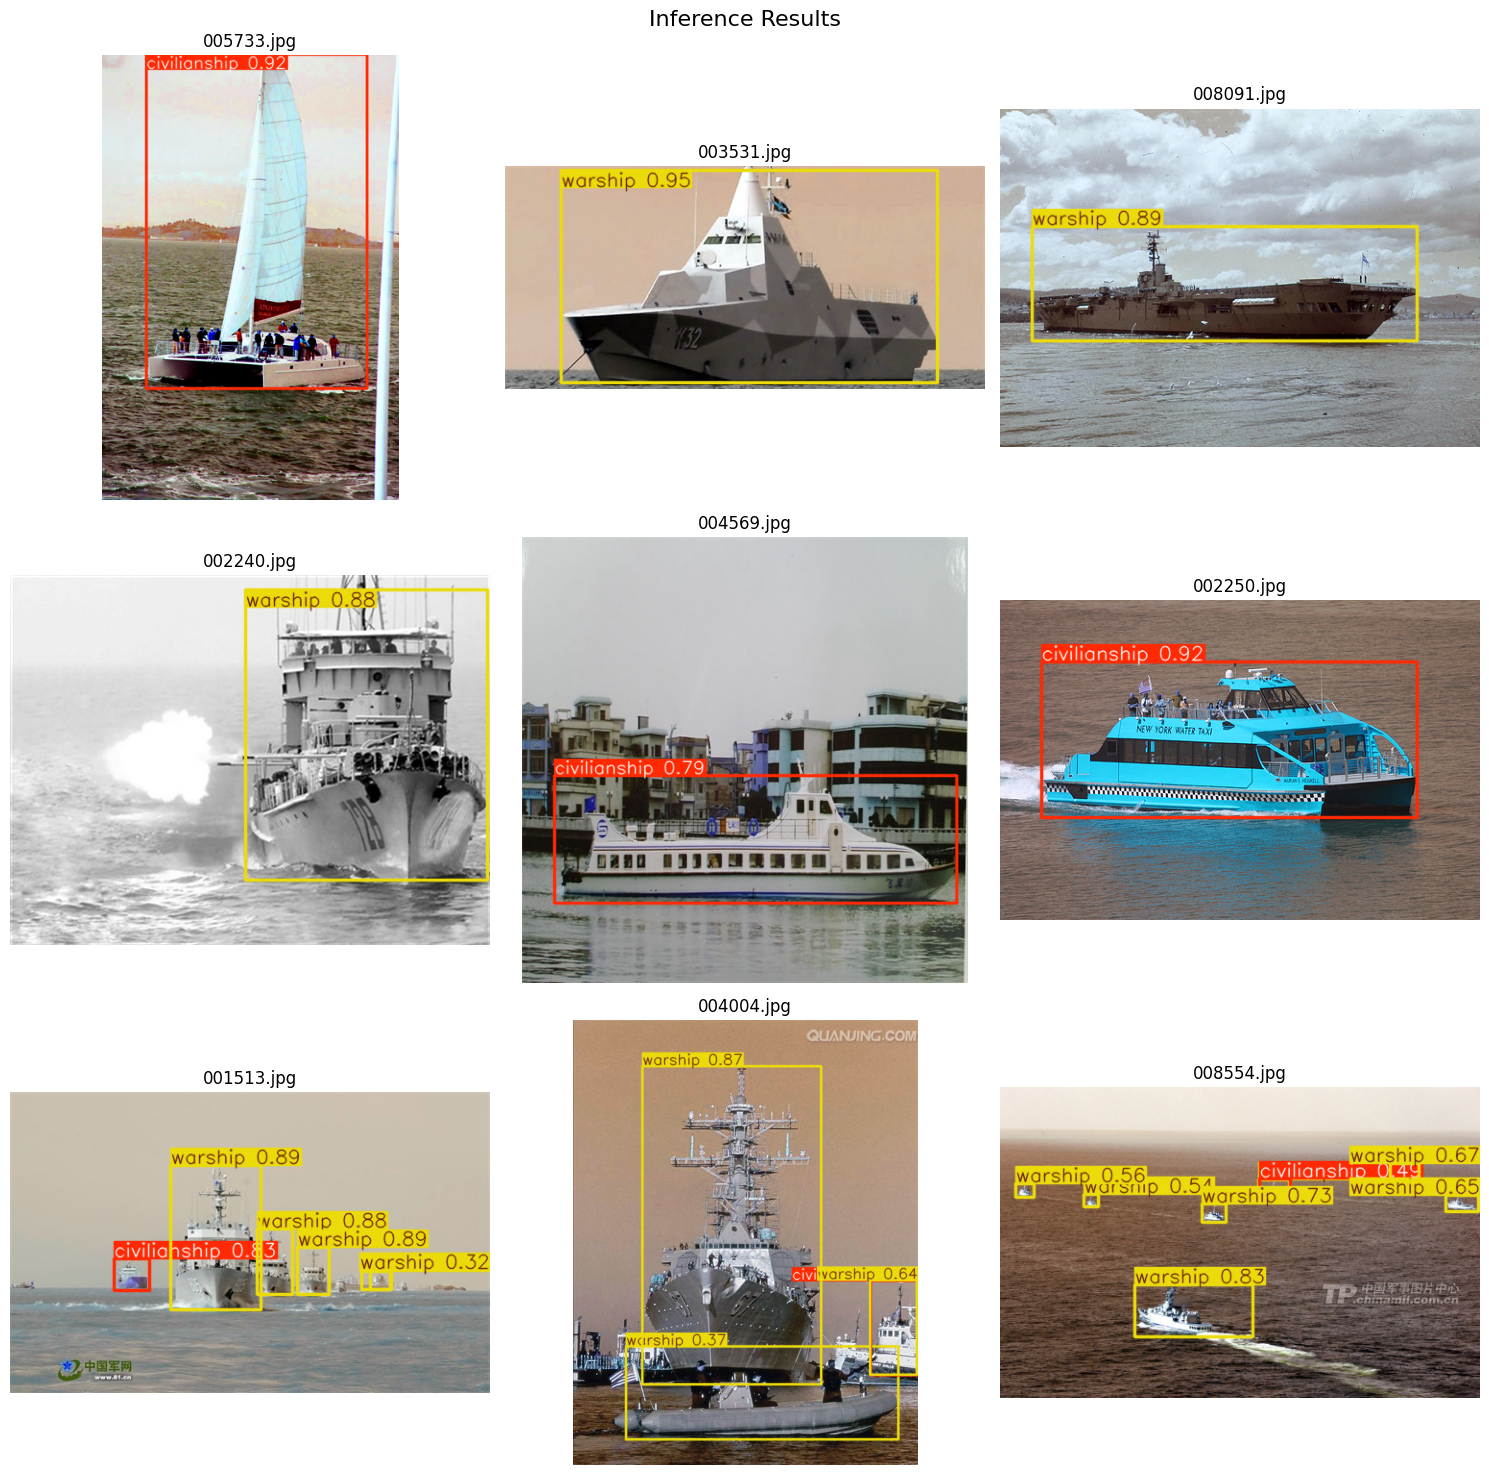

In [43]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
fig.suptitle("Inference Results", fontsize=16)

for result, image_path, ax in zip(results, random_images, axes.ravel()):
    filename = os.path.splitext(os.path.basename(image_path))[0]
    
    img_with_boxes = result.plot(show=False)
    
    ax.imshow(img_with_boxes)
    ax.axis('off') 
    ax.set_title(filename + ".jpg")

# Adjust layout and display the grid
plt.tight_layout()
plt.subplots_adjust(top=0.95)  # Adjust title position
plt.show()

The results show that the finetuned model performed well, with most detections correctly identifying the ship type. This suggests that the model can be effective for the intended application in defense surveillance, providing reliable differentiation between civilian and warship vessels.

# Video Tracking

Video tracking is particularly important for defense surveillance applications, where persistent and accurate tracking of moving targets is essential.

The videos used for tracking focused on maritime surveillance, sourced from YouTube.

For the video tracking evaluation, both BoT-SORT and ByteTrack were applied to the tracked vessels in a series of video clips. 

The goal was to assess how effectively each tracker could maintain object identity and follow the ships over time. 

In [11]:
videos_path = ".\\videos"
all_videos_paths = glob(f'{videos_path}\\*.mp4')
all_videos_paths

['.\\videos\\1.mp4', '.\\videos\\2.mp4', '.\\videos\\3.mp4']

In [12]:
output_dir = os.path.join(videos_path, 'tracking_outputs')
output_dir

'.\\videos\\tracking_outputs'

In [13]:
model = YOLO("./runs/detect/train6/weights/best.pt")

In [14]:
all_videos_paths[0]

'.\\videos\\1.mp4'

In [15]:
for video_path in all_videos_paths:
    video_name = video_path.split("\\")[-1].replace(".mp4", "")
    
    # Track and save results
    model.track(source=video_path, tracker='./botsort.yaml', save=True, name=f'botsort/{video_name}')
    model.track(source=video_path, tracker='./bytetrack.yaml', save=True, name=f'bytetrack/{video_name}')



WARNING  inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/62) C:\Users\yangy\Downloads\red-dragon-advanced-cv-course-project\videos\1.mp4: 384x640 2 civilianships, 1 warship, 38.5ms
video 1/1 (frame 2/62) C:\Users\yangy\Downloads\red-dragon-advanced-cv-course-project\videos\1.mp4: 384x640 2 civilianships, 1 warship, 10.0ms
video 1/1 (frame 3/62) C:\Users\yangy\Downloads\red-dragon-advanced-cv-course-project\videos\1.mp4: 384x640 2 civilianships, 1 warship, 11.0ms
video 1/1 (frame 4/62) C:\Use

In [15]:
bot_sort_videos = [
    r'./runs/detect/botsort/1/1.avi',
    r'./runs/detect/botsort/2/2.avi',
    r'./runs/detect/botsort/3/3.avi'
]

byte_track_videos = [
    r'./runs/detect/bytetrack/1/1.avi',
    r'./runs/detect/bytetrack/2/2.avi',
    r'./runs/detect/bytetrack/3/3.avi'
]

In [16]:
# Somehow Jupyter does not work well with avi files in HTML, so we convert to .mp4 format
for bot_sort_video_path, byte_track_video_path in zip(bot_sort_videos, byte_track_videos):
    bot_sort_video_mp4_path = bot_sort_video_path.replace('.avi', '.mp4')
    byte_track_video_mp4_path = byte_track_video_path.replace('.avi', '.mp4')
    
    os.system(f"ffmpeg -i {bot_sort_video_path} -vcodec libx264 {bot_sort_video_mp4_path}")
    os.system(f"ffmpeg -i {byte_track_video_path} -vcodec libx264 {byte_track_video_mp4_path}")

In [17]:
bot_sort_videos_mp4 = [video_path.replace('.avi', '.mp4') for video_path in bot_sort_videos]
byte_track_videos_mp4 = [video_path.replace('.avi', '.mp4') for video_path in byte_track_videos]

In [18]:
html_content = """
<table style="width:100%; border: 1px solid black; border-collapse: collapse;">
    <tr>
        <th style="border: 1px solid black; padding: 8px; text-align: center;">BoT-SORT (Base configuration from Ultralytics)</th>
        <th style="border: 1px solid black; padding: 8px; text-align: center;">ByteTrack (Base configuration from Ultralytics)</th>
    </tr>
"""

# Loop through each video and add the rows to the table
for i, (bot_sort_video, byte_track_video) in enumerate(zip(bot_sort_videos_mp4, byte_track_videos_mp4)):
    html_content += f"""
    <tr>
        <td style="border: 1px solid black; padding: 8px; text-align: center;">
            <p><strong>Video {i+1} (BoT-SORT)</strong></p>
            <video width="480" controls>
                <source src="{bot_sort_video}" type="video/mp4">
            </video>
        </td>
        <td style="border: 1px solid black; padding: 8px; text-align: center;">
            <p><strong>Video {i+1} (ByteTrack)</strong></p>
            <video width="480" controls>
                <source src="{byte_track_video}" type="video/mp4">
            </video>
        </td>
    </tr>
    """

html_content += """
</table>
"""

display(HTML(html_content))


The tracking and classification results are generally quite good. 

The tracks produced by BoT-SORT and ByteTrack are also largely similar. However, it's possible that both trackers perform well because the ships are relatively unobstructed. I couldn't find a video to further test this hypothesis, but it's certainly an area worth exploring in the future.

Interestingly, in Video 2, both tracking systems identified the wharf near the end of the video, even though the model predicted a relatively low confidence level (~10 to 20%). To the human eye, the wharf closely resembles a ship or submarine, so this outcome seems both understandable and forgivable.